# River Boundary Masking

## Introduction

Plan:

* Stitch together RGB images with openCV sticher (done)
* Find best descriptor for colorspace invariance (done)
* Slice them according to IR images (done)

* Create training data by hand, start using exiting river masks
* Split dataset into training, testing and validation
* Use pre-trained classification model with final layer removed for transfer learning
* Train it on training dataset and evaluate performance

Note to self:
ir_image_{x} matches with cropped_{x-1} and with truth_{x}

The first step is to build our ground truth dataset. It seems that the original processing done in 2012 included some preliminary river masks. Unfortunately, these masks are fairly poor. They also do not help with the construction of our ground truth dataset; it is easier to just manually create label images using the fill tool in paint.net using RGB images layered with transparency over the IR images.

Reflectance of water is lower than soil and vegetation across a wide range of the electromagnetic spectrum, including within the visible RGB portion, but it is significantly lower in the IR range. This means that while both the RGB and IR remote sensing imagery will prove relevant to the model, the IR images will be the key to accurate segmentation. 

![Quadrant Filtering](../img/reflectance.png)

In [2]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import numpy as np
import util

from pathlib import Path
from typing import Any, Callable, Optional
import matplotlib.pyplot as plt
from PIL import Image as im
import cv2

import torch
from torchvision import transforms
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader

In [20]:
"""
Adapted from Manpreet Singh Minhas's transfer learning
for semantic segmentation tutorial.
"""

class SegmentationDataset(VisionDataset):
  """A PyTorch dataset for image segmentation task.
  The dataset is compatible with torchvision transforms.
  The transforms passed would be applied to both the Images and Masks.
  """
  def __init__(self,
    root: str,
    ir_folder: str,
    rgb_folder: str,
    masks_folder: str,

    ir_prefix: str,
    rgb_prefix: str,
    masks_prefix: str,

    transforms: Optional[Callable] = None,
    seed: int = None,
    fraction: float = None,
    subset: str = None,
    
    mask_color_mode: str = "grayscale") -> None:
    """
    ARGS:
    root (str): Used for super init of VisionDataset.
    ir_folder (str): Folder containing the ir images.
    rgb_folder (str): Folder containing the rgb images.
    masks_folder (str): Folder containing the segmentation truth mask images.
    ir_prefix (str): Prefix string for ir images, e.g. "ir_image_" if stored as ir_image_1, ir_image_2 ...
    rgb_prefix (str): Prefix string for the rgb images.
    masks_prefix (str): Prefix string for the segmentation truth mask images.

    transforms (Optional[Callable], optional): A function/transform that takes in
        a sample and returns a transformed version. E.g, ``transforms.ToTensor`` for images.
    seed (int, optional): Specify a seed for the train and test split for reproducible results. Defaults to None.
    fraction (float, optional): A float value from 0 to 1 which specifies the validation split fraction. Defaults to None.
    subset (str, optional): 'Train' or 'Test' to select the appropriate set. Defaults to None.

    mask_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'grayscale'.
    
    RAISES:
    OSError: If any of ir_folder, rgb_folder or masks_folder do not exist.
    ValueError: If subset is not either 'Train' or 'Test'.
    ValueError: If image_color_mode and mask_color_mode are either 'rgb' or 'grayscale'.
    """
    super().__init__(root, transforms)

    ir_images_path = Path(self.root) / ir_folder
    rgb_images_path = Path(self.root) / rgb_folder
    mask_images_path = Path(self.root) / masks_folder

    if not ir_images_path.exists():
      raise OSError(f"{ir_images_path} does not exist.")
    if not rgb_images_path.exists():
      raise OSError(f"{rgb_images_path} does not exist.")
    if not mask_images_path.exists():
      raise OSError(f"{mask_images_path} does not exist.")

    if mask_color_mode not in ["rgb", "grayscale"]:
      raise ValueError(f"{mask_color_mode} is an invalid choice. Please enter from rgb grayscale.")
    self.mask_color_mode = mask_color_mode

    if not fraction:
      self.mask_names = sorted(mask_images_path.glob(masks_prefix + "*"))
    else:
      if subset not in ["Train", "Test"]:
        raise ValueError(f"{subset} is not a valid input. Acceptable values are Train and Test.")
      
      self.fraction = fraction
      self.mask_list = np.array(sorted(mask_images_path.glob(masks_prefix + "*"), key=util.onlyNumeric))
      print(f"Found and loaded {len(self.mask_list)} ground truth segmentation masks.")
      
      # we don't have an rgb reconstruction for every ir image
      # and definitely don't have a mask for every rgb + ir pair
      self.ir_image_list = []
      self.rgb_image_list = []
      for mask in self.mask_list:
        number = util.onlyNumeric(mask)
        self.ir_image_list.append(ir_images_path / (ir_prefix + number + ".png"))
        self.rgb_image_list.append(rgb_images_path / (rgb_prefix + number + ".png"))

      self.ir_image_list = np.array(self.ir_image_list)
      self.rgb_image_list = np.array(self.rgb_image_list)
      assert len(self.ir_image_list) == len(self.rgb_image_list) == len(self.mask_list)

      if seed:
        np.random.seed(seed)
        indices = np.arange(len(self.mask_list))
        np.random.shuffle(indices)

        self.ir_image_list = self.ir_image_list[indices]
        self.rgb_image_list = self.rgb_image_list[indices]
        self.mask_list = self.mask_list[indices]


      if subset == "Train":
        self.ir_image_names = self.ir_image_list[:int(
          np.ceil(len(self.ir_image_list) * (1 - self.fraction)))]
        self.rgb_image_names = self.rgb_image_list[:int(
          np.ceil(len(self.ir_image_list) * (1 - self.fraction)))]
        self.mask_names = self.mask_list[:int(
          np.ceil(len(self.mask_list) * (1 - self.fraction)))]
      else:
        self.ir_image_names = self.ir_image_list[
          int(np.ceil(len(self.ir_image_list) * (1 - self.fraction))):]
        self.rgb_image_names = self.rgb_image_list[
          int(np.ceil(len(self.rgb_image_list) * (1 - self.fraction))):]
        self.mask_names = self.mask_list[
          int(np.ceil(len(self.mask_list) * (1 - self.fraction))):]
        
      print(f"Subset of {len(self.mask_names)} ground truth segmentation masks marked for {subset}.")

  def __len__(self) -> int:
    return len(self.mask_names)
  
  def __getitem__(self, index: int) -> Any:
    ir_image_path = self.ir_image_names[index]
    rgb_image_path = self.rgb_image_names[index]
    mask_path = self.mask_names[index]

    with (
        open(ir_image_path, "rb") as ir_image_file, 
        open(rgb_image_path, "rb") as rgb_image_file, 
        open(mask_path, "rb") as mask_file
      ):
        ir_image = im.open(ir_image_file)
        ir_image = ir_image.convert("L")
        
        rgb_image = im.open(rgb_image_file)
        rgb_image = rgb_image.convert("RGB")
        
        mask = im.open(mask_file)
        if self.mask_color_mode == "rgb":
          mask = mask.convert("RGB")
        
        sample = {
          "ir": ir_image, "rgb": rgb_image, "mask": mask,
          "ir_path": ir_image_path, "rgb_path": rgb_image_path, "mask_path": mask_path
        }
        if self.transforms:
          sample["ir"] = self.transforms(sample["ir"])
          sample["rgb"] = self.transforms(sample["rgb"])
          sample["mask"] = self.transforms(sample["mask"])
        return sample

In [21]:
ir_folder = "data/img/"
ir_prefix = "airborne_ir_"

rgb_folder = "out/realignment/"
rgb_prefix = "rgb_"

truth_folder = "out/segmentation/"
truth_prefix = "truth_"

data = SegmentationDataset(
    "../", ir_folder, rgb_folder, truth_folder, ir_prefix, rgb_prefix, truth_prefix, 
    transforms=None, seed=1, fraction=0.3, subset="Train", mask_color_mode="rgb"
)
loader = DataLoader(data, batch_size=1, shuffle=False, num_workers=12)

Found and loaded 5 ground truth segmentation masks.
Subset of 4 ground truth segmentation masks marked for Train.


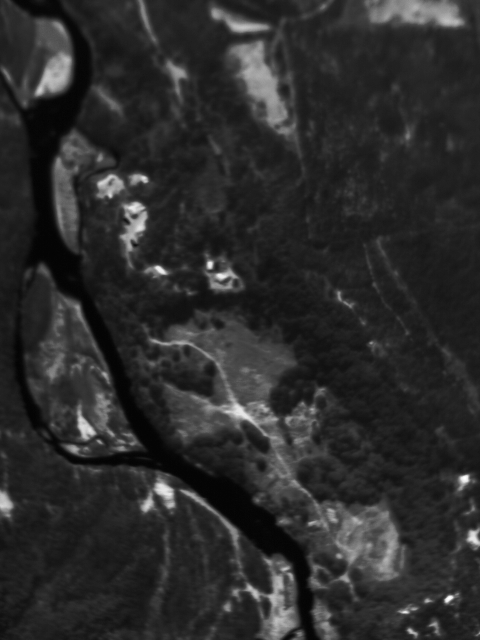

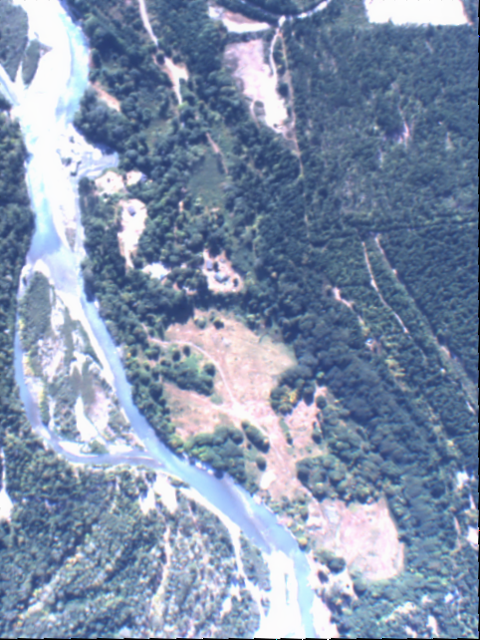

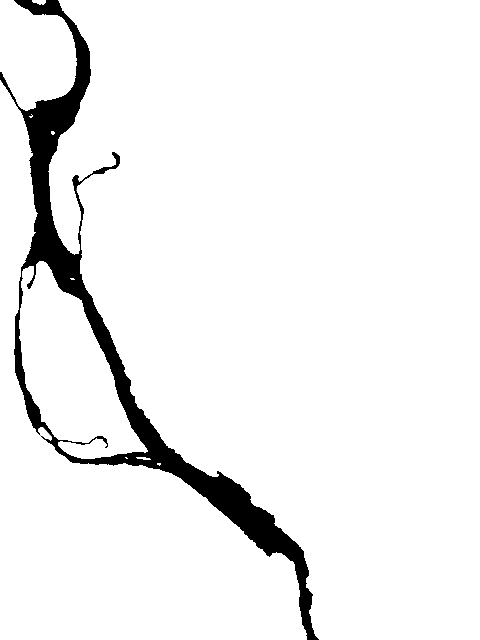

In [22]:
sample_idx = torch.randint(len(data), size=(1,)).item()
datapoint = data[sample_idx] # type: ignore

display(datapoint["ir"])
display(datapoint["rgb"])
display(datapoint["mask"])

Facebook's SAM provides 3 model sizes. For our purposes the smallest of the three, ViT-B, will suffice. The model checkpoint can be downloaded from [this](https://github.com/facebookresearch/segment-anything#model-checkpoints) link.

In [58]:
"""
Adapted from Facebook's SAM predictor 
example workflow notebook.
"""

def show_mask(mask, ax, random_color=False):
  if random_color:
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
  else:
    color = np.array([30/255, 144/255, 255/255, 0.6])
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
  pos_points = coords[labels==1]
  neg_points = coords[labels==0]
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="P", s=marker_size, edgecolor="white", linewidth=1.25)
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="X", s=marker_size, edgecolor="white", linewidth=1.25)   
    
def show_box(box, ax):
  x0, y0 = box[0], box[1]
  w, h = box[2] - box[0], box[3] - box[1]
  ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0,0,0,0), lw=2))    

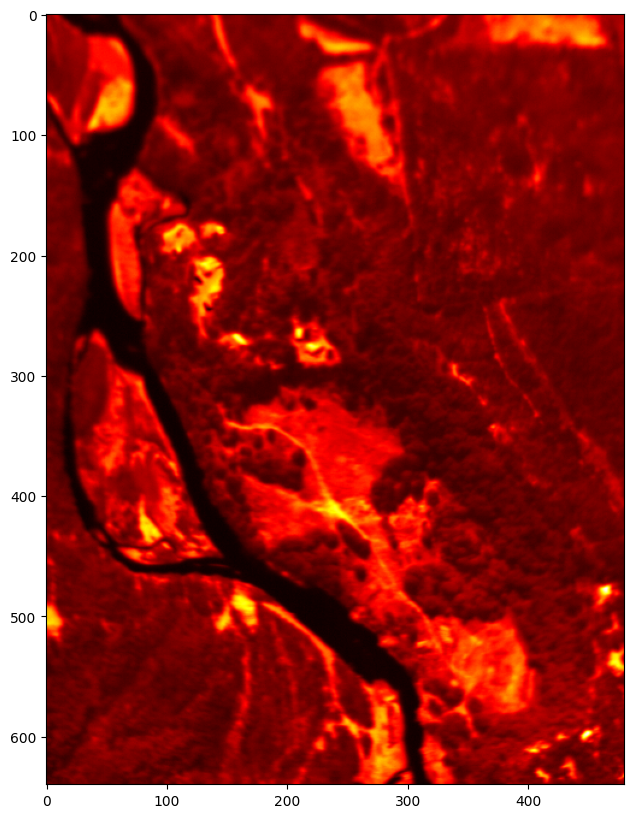

In [47]:
image = cv2.imread(str(datapoint["ir_path"]))
# image = cv2.imread(str(datapoint["rgb_path"]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis("on")
plt.show()

In [26]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "../data/model/sam_vit_b_01ec64.pth"
model_type = "vit_b"

# device = "cuda"
device = None

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [48]:
predictor.set_image(image)

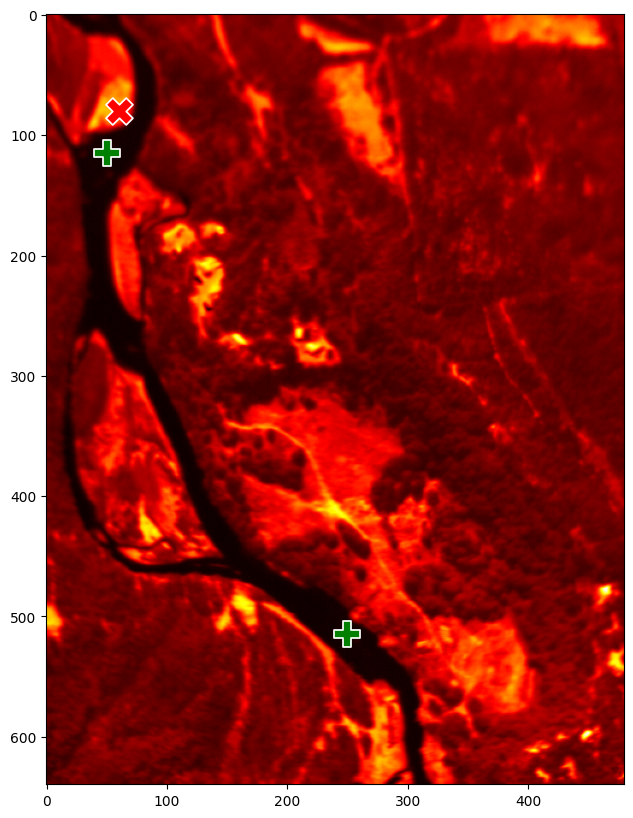

In [59]:
input_point = np.array([[50, 115], [250, 515], [60, 80]])
input_label = np.array([1, 1, 0])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis("on")
plt.show()

In [60]:
masks, scores, logits = predictor.predict(
  point_coords=input_point,
  point_labels=input_label,
  multimask_output=True,
)

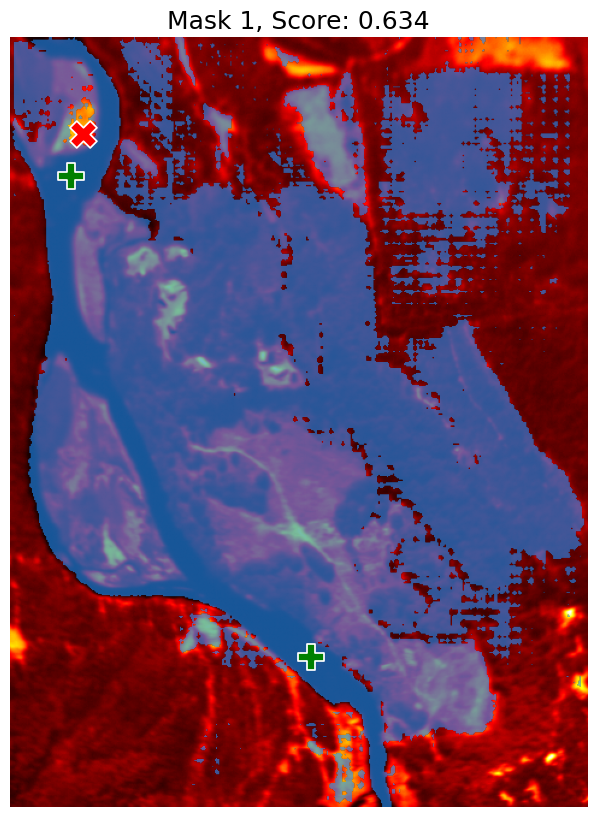

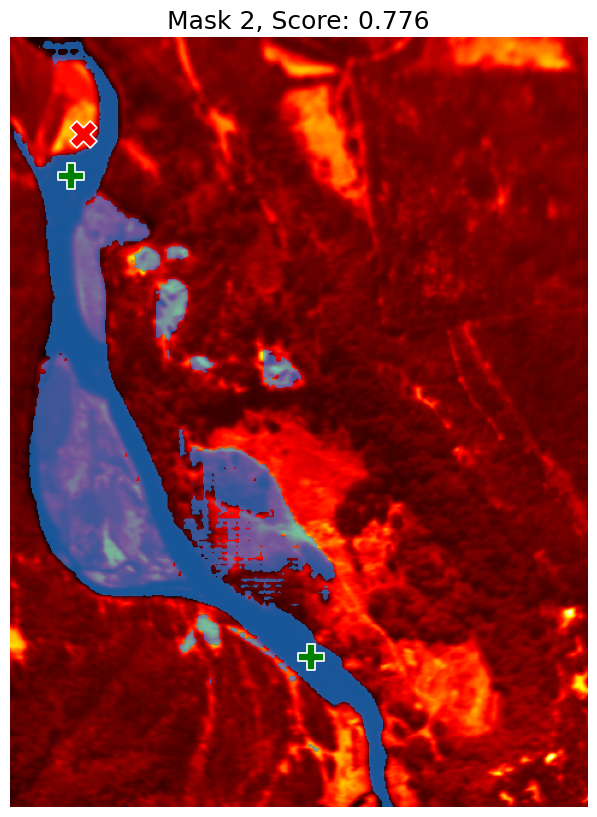

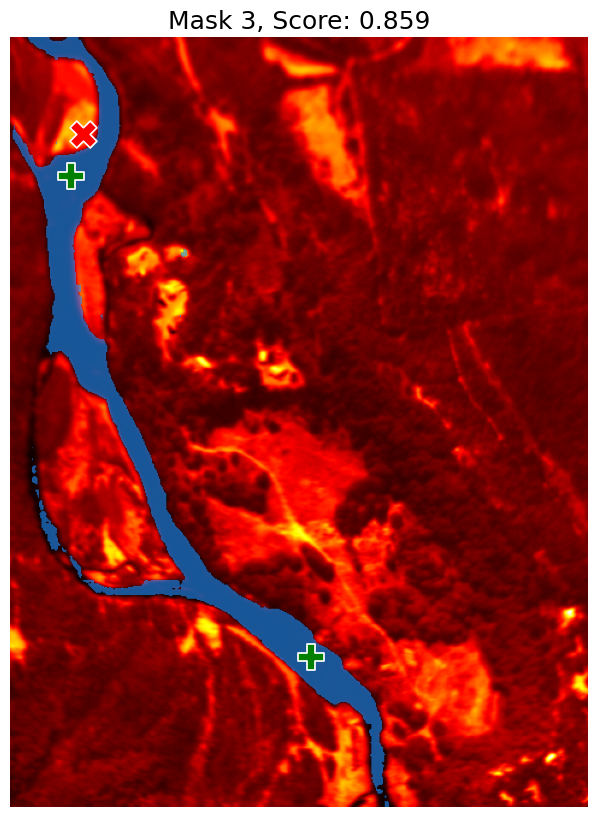

In [61]:
for i, (mask, score) in enumerate(zip(masks, scores)):
  plt.figure(figsize=(10,10))
  plt.imshow(image)
  show_mask(mask, plt.gca())
  show_points(input_point, input_label, plt.gca())
  plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
  plt.axis('off')
  plt.show()  